In [1]:
from pyHalo.PresetModels.cdm import CDM
from pyHalo.PresetModels.wdm import WDM 
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

### Truncation models for subhalos 

pyHalo has several models for truncating subhalos. The most accurate versions are TRUNCATION_GALACTICUS and TRUNCATION_GALACTICUS_KEELEY24. These models track subhalo evolution in a host potential and map from infall concentration and infall time to final bound mass. TRUNCATION_GALACTICUS implements a time-evolving host potential, whereas TRUNCATION_GALACTICUS_KEELEY24 has a static host potential and is discussed by https://ui.adsabs.harvard.edu/abs/2024arXiv240501620K/abstract. 

The following cell generates realizations with different treatments of tidal truncation. We also include the TRUNCATION_GALACTICUS model applied to a concentration-mass relation with enhanced concentrations (by a factor ~3) implemented as a power-law in peak height (see custom_mass_concentration_relations notebook) 

In [20]:
zlens = 0.5
zsource = 2.0

subhalos_cdm = CDM(zlens, zsource, LOS_normalization=0.0, sigma_sub=0.1,
                truncation_model_subhalos='TRUNCATION_GALACTICUS')

subhalos_wdm = WDM(zlens, zsource, log_mc=7.5, LOS_normalization=0.0, sigma_sub=0.1,
                truncation_model_subhalos='TRUNCATION_GALACTICUS')

subhalos_wdm_K24 = WDM(zlens, zsource, log_mc=7.5, LOS_normalization=0.0, sigma_sub=0.1,
                truncation_model_subhalos='TRUNCATION_GALACTICUS_KEELEY24')

# see documentation for PEAK_HEIGHT_POWERLAW mc relation
kwargs_concentration_model = {'c0': 40.0, 'beta': 0.9, 'zeta': 1.0, 'scatter': False}
subhalos_cdm_highc = CDM(zlens, zsource, LOS_normalization=0.0, sigma_sub=0.1,
                truncation_model_subhalos='TRUNCATION_GALACTICUS',
                   concentration_model_subhalos='PEAK_HEIGHT_POWERLAW',
                   kwargs_concentration_model_subhalos=kwargs_concentration_model)

subhalos_cdm_truncation_simple = CDM(zlens, zsource, 
                                     LOS_normalization=0.0, sigma_sub=0.1,
                                    truncation_model_subhalos='TRUNCATION_ROCHE')

([], [])

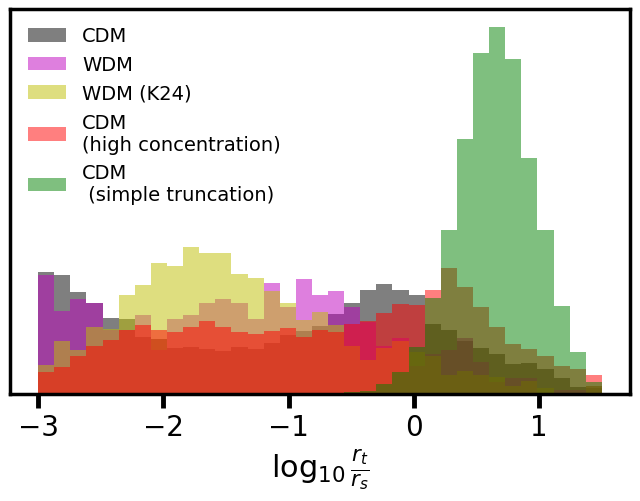

In [21]:
tau_cdm = []
tau_wdm = []
tau_wdm_k24 = []
tau_cdm_highc = []
tau_cdm_truncation_simple = []

for halo in subhalos_cdm.halos:
    params_phys = halo.params_physical
    tau_cdm.append(params_phys['r_trunc_kpc']/params_phys['rs'])
for halo in subhalos_wdm.halos:
    params_phys = halo.params_physical
    tau_wdm.append(params_phys['r_trunc_kpc']/params_phys['rs'])
for halo in subhalos_wdm_K24.halos:
    params_phys = halo.params_physical
    tau_wdm_k24.append(params_phys['r_trunc_kpc']/params_phys['rs'])
for halo in subhalos_cdm_highc.halos:
    params_phys = halo.params_physical
    tau_cdm_highc.append(params_phys['r_trunc_kpc']/params_phys['rs'])
for halo in subhalos_cdm_truncation_simple.halos:
    params_phys = halo.params_physical
    tau_cdm_truncation_simple.append(params_phys['r_trunc_kpc']/params_phys['rs'])
    
fig = plt.figure(1)
fig.set_size_inches(8,5)
_ = plt.hist(np.log10(tau_cdm),bins=35,range=(-3.0, 1.5), color='k',alpha=0.5,density=True,
             label='CDM')
_ = plt.hist(np.log10(tau_wdm),bins=35,range=(-3.0, 1.5), color='m',alpha=0.5,density=True,
            label='WDM')
_ = plt.hist(np.log10(tau_wdm_k24),bins=35,range=(-3.0, 1.5), color='y',alpha=0.5,density=True,
            label='WDM (K24)')
_ = plt.hist(np.log10(tau_cdm_highc),bins=35,range=(-3.0,1.5), color='r',alpha=0.5,density=True,
            label='CDM\n(high concentration)')
_ = plt.hist(np.log10(tau_cdm_truncation_simple),bins=35,range=(-3.0,1.5), color='g',alpha=0.5,density=True,
            label='CDM\n (simple truncation)')

plt.xlabel(r'$\log_{10} \frac{r_t}{r_s}$', fontsize=22)
plt.legend(frameon=False,fontsize=14)
plt.yticks([])

### Bound mass vs. infall concentration 

The TRUNCATION_GALACTICUS models predict a strong correlation between the final bound mass and the infall concentration, as well as infall time 

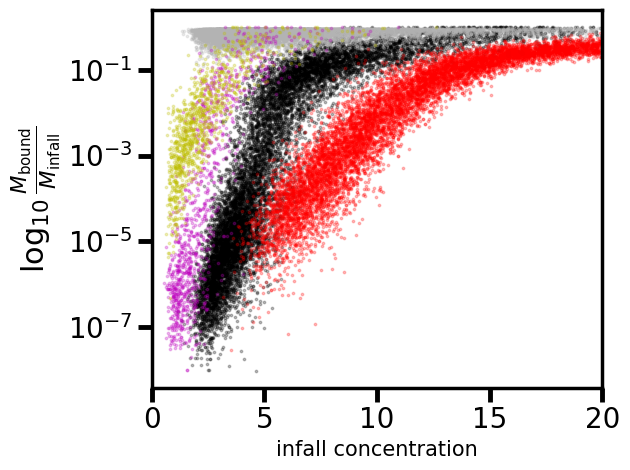

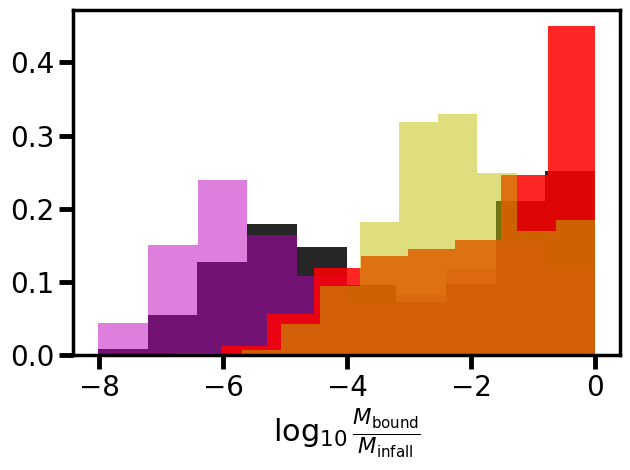

In [25]:
from pyHalo.plotting_routines import plot_subhalo_concentration_versus_bound_mass

fig = plt.figure(1)
ax = plt.subplot(111)
plot_subhalo_concentration_versus_bound_mass(subhalos_cdm, ax, color='k',kwargs_plot={'alpha': 0.25, 's': 3})
plot_subhalo_concentration_versus_bound_mass(subhalos_cdm_truncation_simple, ax, color='0.7',kwargs_plot={'alpha': 0.25, 's': 3})
plot_subhalo_concentration_versus_bound_mass(subhalos_cdm_highc, ax, color='r',kwargs_plot={'alpha': 0.25, 's': 3})
plot_subhalo_concentration_versus_bound_mass(subhalos_wdm, 
                                             ax, color='m',kwargs_plot={'alpha': 0.25, 's': 3})
plot_subhalo_concentration_versus_bound_mass(subhalos_wdm_K24, 
                                             ax, color='y',kwargs_plot={'alpha': 0.25, 's': 3})
ax.set_xlim(0, 20)
plt.tight_layout()

from pyHalo.plotting_routines import plot_bound_mass_histogram

fig = plt.figure(2)
ax = plt.subplot(111)
plot_bound_mass_histogram(subhalos_cdm, ax, color='k',kwargs_plot={'alpha': 0.85})
plot_bound_mass_histogram(subhalos_wdm, ax, color='m',kwargs_plot={'alpha': 0.5})
plot_bound_mass_histogram(subhalos_cdm_highc, ax, color='r',kwargs_plot={'alpha': 0.85})
plot_bound_mass_histogram(subhalos_wdm_K24,ax, color='y',kwargs_plot={'alpha': 0.5})
plt.tight_layout()

### Bound mass vs. infall time 

The TRUNCATION_GALACTICUS models predict a strong correlation between the final bound mass and the infall concentration, as well as infall time 

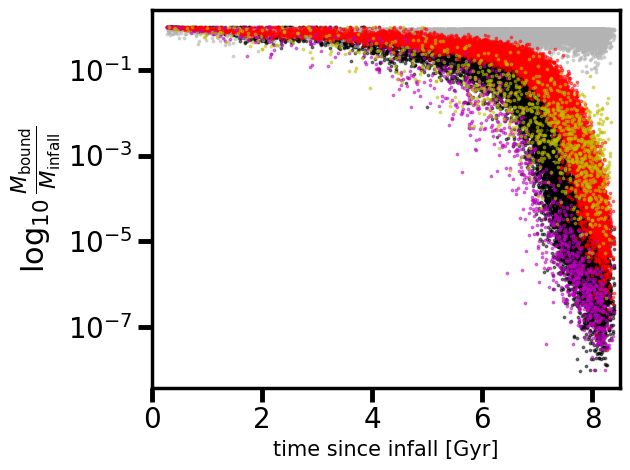

In [28]:
from pyHalo.plotting_routines import plot_subhalo_infall_time_versus_bound_mass

fig = plt.figure(1)
ax = plt.subplot(111)
plot_subhalo_infall_time_versus_bound_mass(subhalos_cdm, ax, color='k',kwargs_plot={'alpha': 0.5, 's': 3})
plot_subhalo_infall_time_versus_bound_mass(subhalos_cdm_truncation_simple, ax, color='0.7',
                                           kwargs_plot={'alpha': 0.5, 's': 3})
plot_subhalo_infall_time_versus_bound_mass(subhalos_cdm_highc, ax, color='r',
                                           kwargs_plot={'alpha': 0.5, 's': 3})
plot_subhalo_infall_time_versus_bound_mass(subhalos_wdm, 
                                             ax, color='m',kwargs_plot={'alpha': 0.5, 's': 3})
plot_subhalo_infall_time_versus_bound_mass(subhalos_wdm_K24, 
                                             ax, color='y',kwargs_plot={'alpha': 0.5, 's': 3})
ax.set_xlim(0, 8.5)
plt.tight_layout()


### pyHalo also adds a truncation to field halos to keep the total mass of realizations finite (NFW profiles are infitinity massive)

Two options include truncation at r50 or at the splashback radius as calculated by colossus. Both give similar results. 

In [29]:
zlens = 0.5
zsource = 2.0
LOS_1 = CDM(zlens, zsource, LOS_normalization=1.0, sigma_sub=0.0)
LOS_2 = CDM(zlens, zsource, LOS_normalization=1.0, sigma_sub=0.0,
           truncation_model_fieldhalos='SPLASHBACK')

In [30]:
tau_LOS_1 = []
tau_LOS_2 = []

for halo in LOS_1.halos:
    params_phys = halo.params_physical
    tau_LOS_1.append(params_phys['r_trunc_kpc']/params_phys['rs'])
for halo in LOS_2.halos:
    params_phys = halo.params_physical
    tau_LOS_2.append(params_phys['r_trunc_kpc']/params_phys['rs'])


([], [])

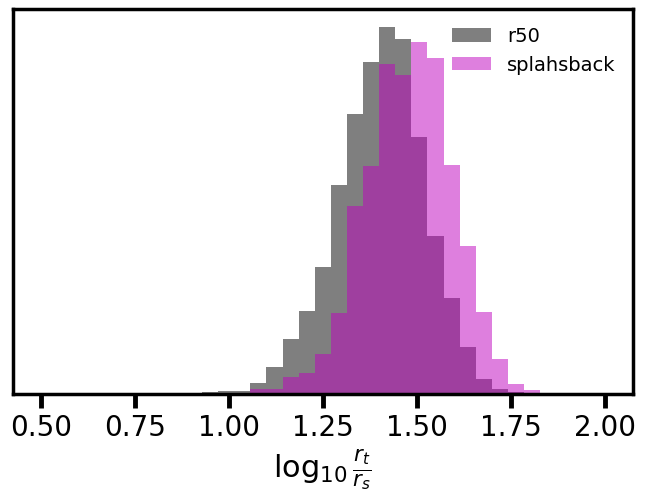

In [31]:
fig = plt.figure(1)
fig.set_size_inches(8,5)
_ = plt.hist(np.log10(tau_LOS_1),bins=35,range=(0.5, 2.0), color='k',alpha=0.5,density=True,
             label='r50')
_ = plt.hist(np.log10(tau_LOS_2),bins=35,range=(0.5, 2.0), color='m',alpha=0.5,density=True,
            label='splahsback')

plt.xlabel(r'$\log_{10} \frac{r_t}{r_s}$', fontsize=22)
plt.legend(frameon=False,fontsize=14)
plt.yticks([])